In [3]:
import os
import pandas as ps
from pandas import DataFrame
import onshape.brepio as brepio
import json
from IPython.display import JSON as DJSON
from IPython.display import clear_output
import numpy as np
from utils import adjacency_list, adjacency_list_from_brepdata, connected_components, homogenize, adjacency_matrix
import sys
import time

### things to count:
- no mates
- disconnected components
- hisogram of number of moving parts

datalistpath = os.path.join('data', 'dof_assemblies.txt')
with open(datalistpath) as f:
    datalist = [[el[1] for el in enumerate(l.strip().split('/')[-7:]) if el[0] == 0 or el[0] == 4 or el[0] == 6] for l in f.readlines()]

## Make dataframes

In [4]:
datapath = '/projects/grail/benjones/cadlab'
loader = brepio.Loader(datapath)

In [5]:
generate_dataframes=False
name = '/fast/jamesn8/assembly_data/assembly_data_with_transforms_all.h5'
#start = 0
start = 125133

In [61]:
if generate_dataframes:
    
    if start == 0:
        with open('filter_list.txt') as f:
            filter_list = f.readlines()
        print('making filter set')
        filter_set = set()
        for l in filter_list:
            filter_set.add(l.strip())
        del filter_list

        valid_dict = dict()

        assembly_rows = []
        assembly_indices = []

        part_rows = []
        mate_rows = []

    j=0 #assembly id
    for entry in os.scandir(os.path.join(datapath,'data','flattened_assemblies')):
        #if j > 3:
        #    break
        if j < start:
            continue
        if not entry.name.endswith('.json') or entry.name in filter_set:
            continue

        occs, mates = loader.load_flattened(entry.name,geometry=False, skipInvalid=True)

        if j % 500 == 0:
            clear_output(wait=True)
            display(f'num_processed: {j}')

        adj_list = adjacency_list_from_brepdata(occs, mates)
        if len(adj_list) > 0:
            adj = homogenize(adj_list)
        else:
            adj = np.zeros([0,0],np.int32)
        num_lone = adj.shape[0] if adj.shape[1] == 0 else (adj[:,0] < 0).sum()
        #num_connections = np.sum(adj, 0)
        #num_lone = len([c for c in num_connections if c == 0])

        num_components = connected_components(adj)
        num_rigid = connected_components(adj, connectionType='fasten')

        num_part_mates = 0
        for mate in mates:
            if len(mate.matedEntities) == 2:
                num_part_mates += 1
                axes = []
                origins = []
                for me in mate.matedEntities:
                    #tf = occs[me[0]][0]
                    #newaxes = tf[:3, :3] @ me[1][1]
                    #neworigin = tf[:3,:3] @ me[1][0] + tf[:3,3]
                    axes.append(me[1][1])
                    origins.append(me[1][0])
                mate_rows.append([np.int32(j), mate.matedEntities[0][0], mate.matedEntities[1][0], mate.type, origins[0].astype(np.float32), axes[0].astype(np.float32), origins[1].astype(np.float32), axes[1].astype(np.float32), mate.name])

        assembly_rows.append([os.path.splitext(entry.name)[0], np.int32(num_components), np.int32(num_rigid), np.int32(num_lone), np.int32(len(occs)), np.int32(num_part_mates), np.int32(len(mates))])
        assembly_indices.append(np.int32(j)) 
        
        for occ in occs:
            part = occs[occ][1]
            did = part['documentId']
            mv = part['documentMicroversion']
            eid = part['elementId']
            config = part['fullConfiguration']
            if 'partId' in part:
                pid = part['partId']
            else:
                pid = ''
            filepath = os.path.join(did, mv, eid, config, f'{pid}.xt')
            
            if filepath in valid_dict:
                isValid = valid_dict[filepath]
            else:
                filepath = os.path.join(datapath, 'data/models', filepath)
                isValid = os.path.isfile(filepath)
                valid_dict[filepath] = isValid
            
            part_rows.append([np.int32(j), occ, did, mv, eid, config, pid, occs[occ][0].astype(np.float32), isValid])

        j += 1

    print('building dataframes...')
    assembly_df = DataFrame(assembly_rows, index=assembly_indices, columns=['AssemblyPath','ConnectedComponents','RigidPieces','LonePieces', 'NumParts', 'NumBinaryPartMates', 'TotalMates'])
    mate_df = DataFrame(mate_rows, columns=['Assembly','Part1','Part2','Type','Origin1','Axes1','Origin2','Axes2','Name'])
    part_df = DataFrame(part_rows, columns=['Assembly','PartOccurrenceID','did','mv','eid','config','PartId', 'Transform', 'HasGeometry'])

    print('saving dataframes...')
    assembly_df.to_hdf(name,'assembly')
    mate_df.to_hdf(name,'mate')
    part_df.to_hdf(name,'part')
    del assembly_rows
    del part_rows
    del mate_rows
    del assembly_indices
    del valid_dict
else:
    assembly_df = ps.read_hdf(name,'assembly')
    mate_df = ps.read_hdf(name,'mate')
    part_df = ps.read_hdf(name,'part')

In [7]:
assembly_df['HasAllGeometry'] = part_df.groupby('Assembly')['HasGeometry'].agg(all)

In [8]:
mate_df_indexed = mate_df.set_index('Assembly')

In [9]:
part_df_updated = ps.read_hdf(name+'_segmentation.h5','part')

In [10]:
part_df_updated.set_index('Assembly', inplace=True)

### Create part-specific data

In [279]:
def path_from_row(part_row):
    return os.path.join(datapath, 'data/models', *[part_row[k] for k in ['did','mv','eid','config']], f'{part_row["PartId"]}.xt')

In [282]:
allpaths = set(path_from_row(part_df_updated.iloc[inde]) for inde in part_df_updated.index)

### Incorporate Deduplication

In [17]:
deduped_df = ps.read_parquet(os.path.join(datapath, 'data/deduped_assembly_list.parquet'))
deduped_df.drop('is_unique', axis=1, inplace=True)
deduped_df['AssemblyPath'] = ['_'.join(me) for me in zip(deduped_df['assembly_documentId'], deduped_df['assembly_documentMicroversion'], deduped_df['assembly_elementId'])]
deduped_df.set_index('AssemblyPath', inplace=True)
deduped_df_joined = assembly_df.join(deduped_df, on='AssemblyPath', how='inner')
deduped_df_joined['HasAllGeometry'] = part_df.groupby('Assembly')['HasGeometry'].agg(all).loc[deduped_df_joined.index]

In [18]:
deduped_df_filtered = deduped_df_joined[lambda df: df['HasAllGeometry']]
deduped_df_movingparts = deduped_df_filtered[lambda df: df['RigidPieces'] > 1]
deduped_df_movingparts_connected = deduped_df_movingparts[lambda df: df['ConnectedComponents'] == 1]

In [19]:
print(f'Total non-subassemblies: %d' % assembly_df.shape[0])
print(f'Total deduplicated non-sub-assemblies: %d (%.2f%%)' % (deduped_df_joined.shape[0], deduped_df_joined.shape[0]/assembly_df.shape[0]*100))
print(f'Total deduplicated with all geometry: %d (%.2f%%)' % (deduped_df_filtered.shape[0], deduped_df_filtered.shape[0]/assembly_df.shape[0]*100))
num_with_multiple_rigid = deduped_df_movingparts.shape[0]
num_fully_connected = sum(deduped_df_filtered['ConnectedComponents'] == 1)
num_fully_connected_multiple_rigid = deduped_df_movingparts_connected.shape[0]

print(f'Assemblies with more than 1 rigid piece: %d (%.2f %% of deduplicated assemblies)' % (num_with_multiple_rigid, num_with_multiple_rigid/deduped_df_filtered.shape[0]*100))
#print(f'Assemblies fully connected: %d (%.2f %% of deduplicated assemblies)' % (num_with_multiple_rigid, num_with_multiple_rigid/deduped_df_filtered.shape[0]*100))
print(f'Assemblies with more than 1 rigid piece that are fully connected: %d (%.2f %% of assemblies with more than 1 rigid piece)' % (num_fully_connected_multiple_rigid, num_fully_connected_multiple_rigid/num_with_multiple_rigid*100))

Total non-subassemblies: 125133
Total deduplicated non-sub-assemblies: 82333 (65.80%)
Total deduplicated with all geometry: 48877 (39.06%)
Assemblies with more than 1 rigid piece: 35806 (73.26 % of deduplicated assemblies)
Assemblies with more than 1 rigid piece that are fully connected: 26953 (75.28 % of assemblies with more than 1 rigid piece)


# Multi-mate analysis
**Notes**:
- Multi-mates containing a fasten are considered a fasten (but still counted)
- exact duplicate mates have been removed for this analysis
### Filter out mates with the same part

In [145]:
mate_df_filtered = mate_df[mate_df['Part1'] != mate_df['Part2']]

### Filter out duplicates

In [135]:
flattened_mateinfo = mate_df_filtered[['Origin1','Origin2','Axes1','Axes2']].apply(lambda x: [tuple(l.flatten()) for l in x])

In [136]:
flattened_mateinfo['Assembly'] = mate_df_filtered['Assembly']
flattened_mateinfo['Part1'] = mate_df_filtered['Part1']
flattened_mateinfo['Part2'] = mate_df_filtered['Part2']
flattened_mateinfo['Type'] = mate_df_filtered['Type']

In [137]:
mate_exact_duplicates = flattened_mateinfo.duplicated(keep='first')

In [138]:
mate_exact_duplicates.sum()

2403

In [139]:
mate_df_filtered = mate_df_filtered[~mate_exact_duplicates]

In [154]:
mate_df_filtered.loc[mate_exact_duplicates,'Assembly'].unique().shape

(1336,)

### Analyze mates between the same parts

In [29]:
mate_dofs = DataFrame(np.array([
    [0,0,0,0,0,0],
    [0,0,0,0,0,1],
    [0,0,1,0,0,0],
    [1,1,0,0,0,1],
    [0,0,1,0,0,1],
    [0,0,0,1,1,1],
    [1,1,1,0,0,1],
    [1,0,0,0,0,1]
]),index=['FASTENED','REVOLUTE','SLIDER','PLANAR','CYLINDRICAL','BALL','PARALLEL','PIN_SLOT'],columns=['pos1','pos2','pos3','rot1','rot2','rot3'])

In [30]:
mate_dofs_reverse = mate_dofs.copy()
mate_dofs_reverse['Type'] = mate_dofs.index
mate_dofs_reverse = mate_dofs_reverse.set_index(['pos1','pos2','pos3','rot1','rot2','rot3'])

In [160]:
mate_df_indexed = mate_df_filtered.copy()

In [161]:
mate_df_indexed['MateID'] = [str(tup[0]) + '-' + '-'.join(sorted(tup[1:])) for tup in zip(mate_df_indexed['Assembly'], mate_df_indexed['Part1'], mate_df_indexed['Part2'])]
mate_df_indexed.set_index('MateID', inplace=True)


In [162]:
duplicate_indices = mate_df_indexed.index.duplicated(False)

In [163]:
duplicate_indices.sum()

313029

In [34]:
mate_duplicates = mate_df_indexed[duplicate_indices]

In [35]:
multimate_groups = mate_duplicates.groupby(by='MateID')

In [36]:
def prod(lst):
    accum = lst[0].copy()
    for l in lst[1:]:
        accum *= l
    return accum

In [37]:
def join_subtractive(x):
    pos = 3
    rot = 3
    for dof in x:
        dofi = mate_dofs.loc[dof]
        pos_c = 3-dofi[:3].sum()
        rot_c = 3-dofi[3:].sum()
        pos -= pos_c
        rot -= rot_c
    return (max(0,pos), max(0,rot))

In [38]:
aggregated = multimate_groups.agg({'Type':lambda x: 'FASTENED' if 'FASTENED' in list(x) else '-'.join(sorted(list(x))),'Assembly':lambda x:x[0]})

In [39]:
all_groups = mate_df_indexed.groupby(by='MateID')
all_aggregated = all_groups.agg({'Type':lambda x:'-'.join(sorted(list(x))),'Assembly':lambda x:x[0]})

In [40]:
def mate_counts(aggregated_df, keys):
    newkeys = aggregated_df.index.intersection(keys)
    type_values = aggregated_df.loc[newkeys, 'Type']
    flattened = []
    for t in type_values:
        for k in t.split('-'):
            flattened.append(k)
    return type_values.value_counts(), ps.Series(flattened).value_counts()

In [41]:
all_aggregated_by_assembly = all_aggregated.set_index('Assembly')

In [42]:
assemblies_with_multimates = aggregated.set_index('Assembly').index.unique()

In [43]:
index_with_moving_parts_no_multimates = deduped_df_movingparts.index.difference(assemblies_with_multimates)
num_with_moving_parts_no_multimates = len(index_with_moving_parts_no_multimates)
index_fully_connected_moving_no_multimates = deduped_df_movingparts_connected.index.difference(assemblies_with_multimates)
num_fully_connected_moving_no_multimates = len(index_fully_connected_moving_no_multimates)
print(f'Moving assemblies with no multimates: %d (%.2f%% of moving assemblies)' % (num_with_moving_parts_no_multimates, num_with_moving_parts_no_multimates/deduped_df_movingparts.shape[0]*100))
print(f'Moving connected assemblies with no multimates: %d (%.2f%% of moving assemblies)' % (num_fully_connected_moving_no_multimates, num_fully_connected_moving_no_multimates/deduped_df_movingparts.shape[0]*100))

Moving assemblies with no multimates: 27963 (78.10% of moving assemblies)
Moving connected assemblies with no multimates: 20845 (58.22% of moving assemblies)


In [36]:
with open('fully_connected_moving_no_multimates.txt','w') as f:
    for ind in index_fully_connected_moving_no_multimates:
        f.write(f'{ind}\n')

In [31]:
counts_A, counts_A_flattened = mate_counts(all_aggregated_by_assembly, deduped_df_filtered.index)

In [32]:
counts_B, counts_B_flattened = mate_counts(all_aggregated_by_assembly, deduped_df_movingparts.index)

In [33]:
counts_C, counts_C_flattened = mate_counts(all_aggregated_by_assembly, deduped_df_movingparts_connected.index)

In [34]:
counts_D, counts_D_flattened = mate_counts(all_aggregated_by_assembly, index_with_moving_parts_no_multimates)

In [35]:
counts_E, counts_E_flattened = mate_counts(all_aggregated_by_assembly, index_fully_connected_moving_no_multimates)

<AxesSubplot:title={'center':'A'}>

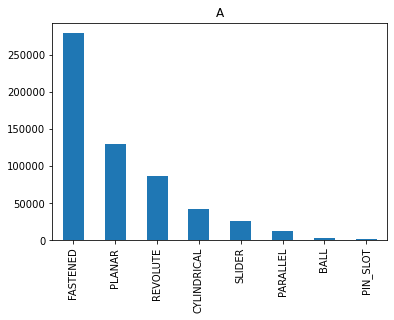

In [253]:
counts_A_flattened.plot.bar(title='A')

<AxesSubplot:title={'center':'B'}>

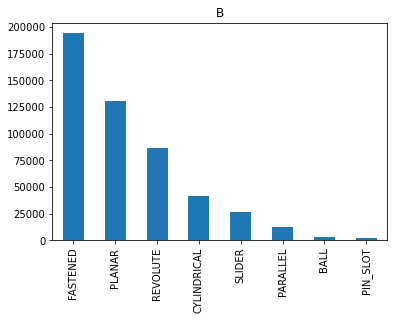

In [254]:
counts_B_flattened.plot.bar(title='B')

<AxesSubplot:title={'center':'C'}>

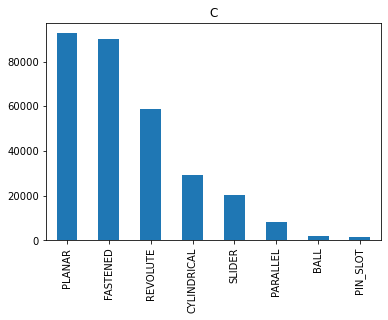

In [255]:
counts_C_flattened.plot.bar(title='C')

<AxesSubplot:title={'center':'D'}>

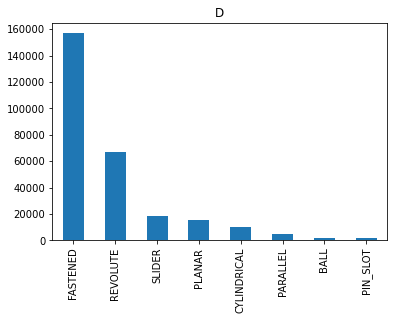

In [256]:
counts_D_flattened.plot.bar(title='D')

<AxesSubplot:title={'center':'E'}>

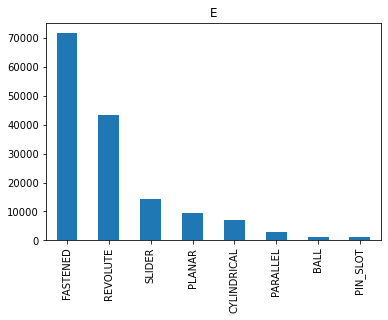

In [257]:
counts_E_flattened.plot.bar(title='E')

In [28]:
def numUnique(lst):
    s = set()
    for l in lst:
        s.add(l)
    return len(s)

In [29]:
all_mate_counts = all_aggregated.groupby('Type').agg({'Assembly':['count',numUnique]})['Assembly'].rename(columns={'numUnique':'numAssemblies'}).sort_values('count', ascending=False)

In [ ]:
all_mate_counts[[len(t.split('-')) == 1 for t in all_mate_counts.index]]

In [ ]:
all_mate_counts[['PARALLEL' in t.split('-') for t in all_mate_counts.index]].to_csv('parallels.csv')

In [83]:
aggregated_dofs = multimate_groups.agg({'Type':lambda x: tuple(prod([mate_dofs.loc[t].to_numpy() for t in x])),'Assembly':lambda x:x[0]})

In [98]:
aggregated_dofs2 = multimate_groups.agg({'Type':join_subtractive,'Assembly':lambda x:x[0]})

In [99]:
aggregated_dofs2

,Type,Assembly
MateID,,
10-MMb6JZl4ks61uaBwr-MS8WYyXlytoCXG1pZ,"(0, 0)",10
100000-Mq3qURmAJRvJ7SkpJ-Mv2mXrkaVwkPdzJ6s,"(1, 0)",100000
100009-M1Qk600l46srC1L9e-MCKAHW47mIKm/jCuX,"(1, 0)",100009
100016-M8SI7IaWgOJefLadF-MAgQILhjNgXd0pkaS,"(0, 0)",100016
10002-M6+nLPUTeSkfTS+cD-MjYZemYeVhYjQHg3D,"(0, 0)",10002
...,...,...
99999-MEwYaMSyoEtu00KHO-MLebwGRtTggG9fr7L,"(0, 0)",99999
99999-MMUKcXHqa3zNhRRa0-MbsnSbKBpxq/hQfTr,"(0, 0)",99999
99999-MRwbE7U4t/0IFUKdz-MdvGdYpK+TZjjQ6iF,"(0, 0)",99999


In [36]:
multimate_counts = aggregated.groupby('Type').agg({'Assembly':['count',numUnique]})['Assembly'].rename(columns={'numUnique':'numAssemblies'}).sort_values('count', ascending=False)

In [86]:
dof_counts = aggregated_dofs.groupby('Type').agg({'Assembly':['count',numUnique]})['Assembly'].rename(columns={'numUnique':'numAssemblies'}).sort_values('count', ascending=False)

In [93]:
dof_counts['Type'] = [mate_dofs_reverse.loc[t] for t in dof_counts.index]
dof_counts = dof_counts.set_index('Type')
dof_counts

,count,numAssemblies
Type,,
[PLANAR],59002,10803
[REVOLUTE],42518,8370
[FASTENED],12856,5281
[CYLINDRICAL],2646,1468
[SLIDER],1109,778
[PARALLEL],1012,663
[BALL],489,131
[PIN_SLOT],422,249


In [101]:
dof_counts2 = aggregated_dofs2.groupby('Type').agg({'Assembly':['count',numUnique]})['Assembly'].rename(columns={'numUnique':'numAssemblies'}).sort_values('count', ascending=False)
#dof_counts2['Type'] = [mate_dofs_reverse.loc[t] for t in dof_counts.index]
#dof_counts2 = dof_counts.set_index('Type')
dof_counts2

,count,numAssemblies
Type,,
"(0, 0)",83550,17720
"(1, 0)",30947,7927
"(2, 0)",3541,1198
"(3, 0)",1012,663
"(0, 1)",515,269
"(0, 3)",489,131


In [45]:
multimate_counts = multimate_counts[multimate_counts.index != 'FASTENED']

In [47]:
multimate_counts.to_csv('multimates-nodups.csv')

In [46]:
for index in multimate_counts.index:
    print(index,list(multimate_counts.loc[index]))

PLANAR-PLANAR [28839, 7060]
CYLINDRICAL-PLANAR [27654, 5485]
PLANAR-PLANAR-PLANAR [25096, 6521]
CYLINDRICAL-CYLINDRICAL-PLANAR [4707, 1378]
PLANAR-SLIDER [3897, 1488]
PARALLEL-PLANAR [3298, 1107]
REVOLUTE-REVOLUTE [2684, 927]
PLANAR-REVOLUTE [2166, 591]
CYLINDRICAL-CYLINDRICAL [1649, 903]
CYLINDRICAL-PARALLEL-PLANAR [1522, 565]
CYLINDRICAL-PLANAR-PLANAR [1199, 494]
CYLINDRICAL-PARALLEL [885, 552]
PARALLEL-PARALLEL [823, 574]
PARALLEL-PLANAR-PLANAR [760, 368]
PARALLEL-REVOLUTE [707, 413]
CYLINDRICAL-REVOLUTE [667, 381]
BALL-BALL [486, 129]
SLIDER-SLIDER [485, 339]
BALL-CYLINDRICAL [334, 138]
PLANAR-PLANAR-PLANAR-PLANAR [315, 216]
PARALLEL-SLIDER [272, 226]
CYLINDRICAL-SLIDER [264, 179]
PARALLEL-PARALLEL-PLANAR [210, 131]
PLANAR-SLIDER-SLIDER [177, 115]
PLANAR-PLANAR-SLIDER [172, 99]
PARALLEL-PARALLEL-PARALLEL-PLANAR-PLANAR-PLANAR [163, 14]
PARALLEL-PARALLEL-PARALLEL [158, 116]
REVOLUTE-SLIDER [143, 106]
PIN_SLOT-PLANAR [139, 62]
PARALLEL-PLANAR-PLANAR-PLANAR [136, 121]
PIN_SLOT-PIN_SLOT

In [57]:
assemblies_with_multimates = set(aggregated['Assembly'])

In [61]:
len(assemblies_with_multimates)/assembly_df.shape[0]

0.18878114536678697

In [51]:
1-multimate_counts['numAssemblies'][20:].sum() / multimate_counts['numAssemblies'][:20].sum()

0.9152181983867157

In [32]:
1-multimate_counts['count'][20:].sum() / multimate_counts['count'][:20].sum()

NameError: name 'multimate_counts' is not defined

# Heuristics

In [45]:
stats_path = '/fast/jamesn8/assembly_data/mate_torch_stats/'
stats_df = ps.concat([ps.read_parquet(os.path.join(stats_path, fname)) for fname in os.listdir(stats_path) if fname.startswith('stats') and fname.endswith('.parquet')], axis=0)
#mate_stats_df = ps.concat([ps.read_parquet(os.path.join(stats_path, fname)) for fname in os.listdir(stats_path) if fname.startswith('mate') and fname.endswith('.parquet')], axis=0)
mate_stats_df = ps.read_parquet(os.path.join(stats_path,'mate_stats_all.parquet'))

FileNotFoundError: [Errno 2] No such file or directory: '/fast/jamesn8/assembly_data/mate_torch_stats/mate_stats_all.parquet'

In [142]:
recorded_mates = mate_stats_df[lambda df: ~df['mc_pair_found'].isnull()]
recorded_mates['total_extra_matches'] = recorded_mates['extra_matches_frame_0'] + recorded_mates['extra_matches_frame_1']

/tmp/ipykernel_1761636/3224859321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recorded_mates['total_extra_matches'] = recorded_mates['extra_matches_frame_0'] + recorded_mates['extra_matches_frame_1']


In [143]:
recorded_assemblies = stats_df[lambda df: ~df['missed_mc_pairs'].isnull()]

In [144]:
mate_stats_df.keys()

Index(['invalid_frame_0', 'invalid_frame_0_coincident_origins',
       'invalid_frame_0_permuted_z', 'matches_frame_0',
       'extra_matches_frame_0', 'invalid_frame_1',
       'invalid_frame_1_coincident_origins', 'invalid_frame_1_permuted_z',
       'matches_frame_1', 'extra_matches_frame_1', 'type',
       'truncated_mc_pairs', 'part_pair_found', 'mc_pair_found'],
      dtype='object')

In [145]:
stats_df.keys()

Index(['total_mates', 'total_parts', 'maxdim', 'total_mcs', 'invalid_frames',
       'invalid_mates', 'invalid_coincident_origins', 'invalid_permuted_z',
       'false_part_pairs', 'missed_part_pairs', 'missed_mc_pairs',
       'num_invalid_transformed_parts', 'num_proposals', 'proposal_time'],
      dtype='object')

types of mates with invalid frames:


<AxesSubplot:>

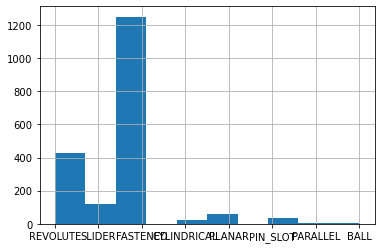

In [146]:
print('types of mates with invalid frames:')
invalid_frames['type'].hist()

In [147]:
invalid_frames = mate_stats_df[lambda df: df['invalid_frame_0'] | df['invalid_frame_1']]
assemblies_with_invalid_frames = stats_df[lambda df: df['invalid_mates'] > 0]
print(f'fraction of mates with an unmatched mate frame:{invalid_frames.shape[0]/mate_stats_df.shape[0]}')
print(f'fraction of assemblies with unmatched mate frames:{assemblies_with_invalid_frames.shape[0]/stats_df.shape[0]}')
#invalid_frames_with_coincident_origins = invalid_frames[lambda df: df['invalid_frame_0_coincident_origins'] | df['invalid_frame_1_coincident_origins']]
#invalid_frames_with_coincident_origins[lambda df: df['invalid_frame_0_permuted_z'] | df['invalid_frame_1_permuted_z']].shape[0]/invalid_frames_with_coincident_origins.shape[0]
#invalid_frames_with_coincident_origins.shape[0]/invalid_frames.shape[0]
missed_mates = recorded_mates[lambda df: ~df['mc_pair_found'].astype(bool)]
missed_part_pairs = recorded_mates[lambda df: ~df['part_pair_found'].astype(bool)]
print(f'fraction of mated connector pairs missed by heuristics: {missed_mates.shape[0]/recorded_mates.shape[0]}')
print(f'fraction of mated part pairs completely missed by heuristics: {missed_part_pairs.shape[0]/recorded_mates.shape[0]}')
print(f'average fraction of mates that are missed by heuristics per assembly: {(recorded_assemblies["missed_mc_pairs"]/recorded_assemblies["total_mates"]).mean()}')
print(f'rate of assemblies with at least one mate missed by heuristics: {recorded_assemblies[lambda df: df["missed_mc_pairs"] > 0].shape[0]/recorded_assemblies.shape[0]}')
print(f'fraction of mates with more than 100000 mated pairs found by heuristics: {mate_stats_df["truncated_mc_pairs"].sum()/mate_stats_df.shape[0]}')
print(f'average number of connector pair proposals per assembly: {recorded_assemblies["num_proposals"].mean()}')
print(f'fraction of assemblies with an error transforming a part: {recorded_assemblies[lambda df: df["num_invalid_transformed_parts"] > 0].shape[0]/recorded_assemblies.shape[0]}')
print(f'average number of parts with transform errors among these assemblies: {recorded_assemblies[lambda df: df["num_invalid_transformed_parts"] > 0]["num_invalid_transformed_parts"].mean()}')
print(f'fraction of assemblies with less than 10000 mate connectors: {recorded_assemblies.shape[0]/stats_df.shape[0]}')
print(f'fraction of assemblies with matching mate frames and no part transform errors: {recorded_assemblies[lambda df: (df["num_invalid_transformed_parts"] == 0 & (df["invalid_mates"] == 0))].shape[0]/stats_df.shape[0]}')

fraction of mates with an unmatched mate frame:0.12755409015426825
fraction of assemblies with unmatched mate frames:0.2663916439919249
fraction of mated connector pairs missed by heuristics: 0.052235470780671804
fraction of mated part pairs completely missed by heuristics: 0.04987575752158601
average fraction of mates that are missed by heuristics per assembly: 0.09229530385152565
rate of assemblies with at least one mate missed by heuristics: 0.13454545454545455
fraction of mates with more than 100000 mated pairs found by heuristics: 0.003056484801809824
average number of connector pair proposals per assembly: 57735.98447174447
fraction of assemblies with an error transforming a part: 0.0457002457002457
average number of parts with transform errors among these assemblies: 1.4172043010752688
fraction of assemblies with less than 10000 mate connectors: 0.8930922496269639
fraction of assemblies with matching mate frames and no part transform errors: 0.8522777143860265


<AxesSubplot:title={'center':'Heuristic recall per mate type'}, xlabel='type'>

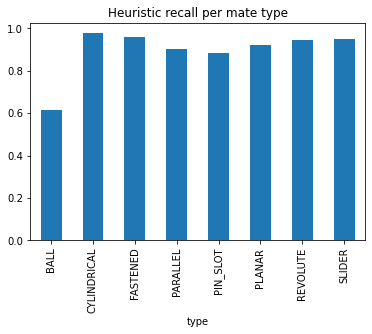

In [160]:
per_type_stats = recorded_mates.groupby('type').agg({'mc_pair_found': sum, 'type': 'count'})
(per_type_stats['mc_pair_found']/per_type_stats['type']).plot.bar(title='Heuristic recall per mate type')

/tmp/ipykernel_1761636/1051429608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recorded_mates['valid'] = ~(recorded_mates['invalid_frame_0'] | recorded_mates['invalid_frame_1'])


<AxesSubplot:title={'center':'Percent of mates that correspond to any connectors per mate type'}, xlabel='type'>

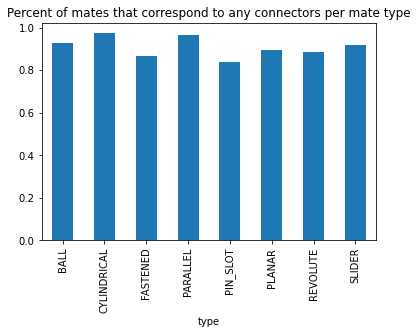

In [153]:
recorded_mates['valid'] = ~(recorded_mates['invalid_frame_0'] | recorded_mates['invalid_frame_1'])
per_type_stats = recorded_mates.groupby('type').agg({'valid': sum, 'type': 'count'})
(per_type_stats['valid']/per_type_stats['type']).plot.bar(title='Percent of mates that correspond to any connectors per mate type')

<AxesSubplot:title={'center':'Average number of extra MC pair matches per mate type'}, xlabel='type'>

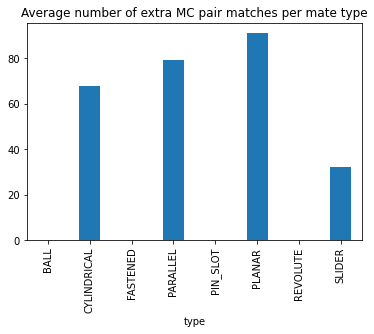

In [157]:
recorded_mates.groupby('type')['total_extra_matches'].agg(np.mean).plot.bar(title='Average number of extra MC pair matches per mate type')

In [154]:
recorded_mates['total_matches'] = recorded_mates['matches_frame_0'] + recorded_mates['matches_frame_1']

/tmp/ipykernel_1761636/2094720822.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recorded_mates['total_matches'] = recorded_mates['matches_frame_0'] + recorded_mates['matches_frame_1']


<AxesSubplot:title={'center':'Average number of MC pair matches per mate type'}, xlabel='type'>

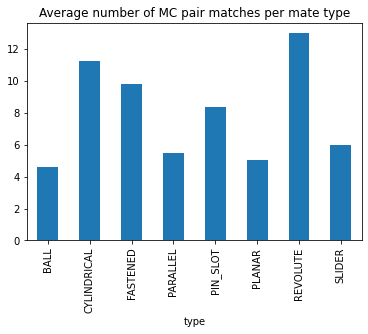

In [156]:
recorded_mates.groupby('type')['total_matches'].agg(np.mean).plot.bar(title='Average number of MC pair matches per mate type')

In [47]:
hasball = mate_df.groupby('Assembly').agg({'Type':lambda x: any([t == 'BALL' for t in x])}).loc[index_fully_connected_moving_no_multimates]

In [53]:
assembly_df.loc[hasball[hasball['Type']].index]

,AssemblyPath,ConnectedComponents,RigidPieces,LonePieces,NumParts,NumBinaryPartMates,TotalMates,HasAllGeometry
214,a5f5816f5492810d0fd66173_336c4e87babaedda4577c...,1,2,0,2,1,1,True
279,87688bb8ccd911995ddc048c_6313170efcc25a6f36e56...,1,24,0,26,25,25,True
717,bc9eecda96f6f5de32e17e2d_9e7cae761db7b91c36ad8...,1,4,0,6,5,5,True
718,25810b6ce462551758ee0299_66b253044fc0ad1377599...,1,2,0,3,2,2,True
722,424fe553afa789d91041a448_66d6b65cc3bb4bb30aee0...,1,2,0,3,2,2,True
...,...,...,...,...,...,...,...,...
124234,79decbd0cf48a95b4a7a9243_0bd38558519d8a08662ed...,1,4,0,4,3,5,True
124361,5953eeb34765f33b4052739d_979a01b235c9c9d8a3a77...,1,4,0,4,3,3,True
124555,3d8a4b9ed2378a582bbead7f_134b296f2139df1f65962...,1,2,0,3,2,2,True
124650,772cc1bdb0e13d11f07d616e_9c0ebdeed806f079e895b...,1,5,0,6,6,6,True


number of mates missed by heuristics, by type, out of 55939


<AxesSubplot:>

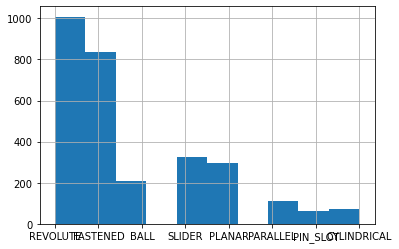

In [159]:
print('number of mates missed by heuristics, by type, out of',recorded_mates.shape[0])
missed_mates['type'].hist()

# Legacy statistics

In [ ]:
skipped = 0

#number of assemblies with lone pieces

c_num_lone_pieces = []

#number of assemblies with disconnected components

c_num_components = []

#number of parts in fully connected assemblies

c_num_parts_connected = []

#number of rigid components in fully connected assemblies

c_num_rigid_connected = []

#same, but without the condition?

c_num_parts = []

c_num_rigid = []

#for data in datalist:
for j,entry in enumerate(os.scandir(os.path.join(datapath,'data','flattened_assemblies'))):
    if j % 1000 == 0:
        print(j)
    if not entry.name.endswith('.json') or entry.name in filter_set:
        continue
    try:
        #occs, mates = loader.load(data[0], data[1], data[2], geometry=False)
        occs, mates = loader.load_flattened(entry.path, geometry=False)
    except KeyError as e:
        #print(e)
        skipped += 1
        continue
    except FileNotFoundError as e:
        #print(e)
        skipped += 1
        continue
    #print(occs, mates)
    adj = adjacency_matrix(occs, mates)
    num_connections = np.sum(adj, 0)
    num_lone = len([c for c in num_connections if c == 0])
    c_num_lone_pieces.append(num_lone)
    
    num_components = connected_components(adj)
    num_rigid = connected_components(adj, connectionType='fasten')
    c_num_components.append(num_components)
    
    c_num_rigid.append(num_rigid)
    c_num_parts.append(adj.shape[0])
    if num_components == 1:
        c_num_parts_connected.append(adj.shape[0])
        c_num_rigid_connected.append(num_rigid)

    
    
print('skipped',skipped)

In [ ]:
num_with_lone_pieces = len([c for c in c_num_lone_pieces if c > 0])
num_fully_connected = len([c for c in c_num_components if c == 1])
num_processed = len(c_num_parts)
print('number of assemblies processed: %d'%num_processed)
print('assemblies with lone pieces: %d (%.2f%%)'%(num_with_lone_pieces, num_with_lone_pieces/num_processed*100))
print('assemblies fully connected: %d (%.2f%%)'%(num_fully_connected, num_fully_connected/num_processed*100))
nbins = 40
plt.hist(c_num_parts, nbins, range=(0, nbins+1))
plt.title('num parts')
plt.show()
plt.hist(c_num_rigid, nbins, range=(0,nbins+1))
plt.title('num rigid components')
plt.show()
plt.hist(c_num_parts_connected, nbins, range=(0, nbins+1))
plt.title('num parts in connected models')
plt.show()
plt.hist(c_num_rigid_connected, nbins, range=(0, nbins+1))
plt.title('num rigid components in connected models')
plt.show()
plt.hist(c_num_lone_pieces, nbins, range=(0, nbins+1))
plt.title('num lone pieces')
plt.show()
plt.hist(c_num_components, nbins, range=(0, nbins+1))
plt.title('num connected components')
plt.show()


In [ ]:
len([c for c in c_num_rigid_connected if c >= 2])

In [ ]:
len([c for c in c_num_parts_connected if c == 2])

In [ ]:
num_with_more_than_2_rigid = len([c for c in c_num_rigid_connected if c > 2])
print(num_with_more_than_2_rigid)
print(num_with_more_than_2_rigid/num_processed*100)

In [ ]:
num_with_more_than_2_parts = len([c for c in c_num_parts_connected if c > 2])
print(num_with_more_than_2_parts)
print(num_with_more_than_2_parts/num_processed*100)

In [ ]:
num_with_lone_parts = len([c for c in c_num_lone_pieces if c > 0])
print(num_with_lone_parts)
print(num_with_lone_parts/num_processed*100)

# Torch + heuristics data generation statistics

In [47]:
statspath = '/fast/jamesn8/assembly_data/assembly_torch2_fixsize/stats'

In [80]:
stats_df = ps.read_parquet(os.path.join(statspath, 'stats_all.parquet'))
mate_stats_df = ps.read_parquet(os.path.join(statspath, 'mate_stats_all.parquet'))

In [81]:
#stats_df_filtered = stats_df[lambda df: ~df['skipped']]

In [118]:
# Filter to our simple dataset as well
with open('/projects/grail/jamesn8/projects/mechanical/Mechanical/data/dataset/simple_valid_dataset.txt','r') as f:
    simple_valid_indices = {int(l) for l in f.readlines()}
newindex = simple_valid_indices.intersection(stats_df.index)
stats_df_filtered = stats_df.loc[newindex]

In [130]:
mate_df_by_ass = mate_df.set_index("Assembly")

In [131]:
mate_df_by_ass['mateId'] = mate_df.index

In [132]:
mate_df_by_ass = mate_df_by_ass.loc[stats_df_filtered.index]

In [121]:
mate_types = [
            'PIN_SLOT',
            'BALL',
            'PARALLEL',
            'SLIDER',
            'REVOLUTE',
            'CYLINDRICAL',
            'PLANAR',
            'FASTENED'
        ]

<AxesSubplot:title={'center':'mate types frequency'}>

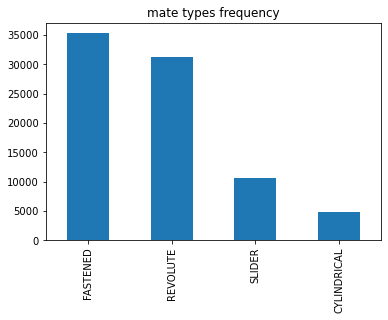

In [141]:
mate_df_by_ass.loc[stats_df_filtered.index]['Type'].value_counts().plot.bar(title='mate types frequency')

### mate data generation statistics

In [125]:
mate_stats_df['type'] = mate_df.loc[mate_stats_df.index, 'Type']

In [126]:
mate_stats_df['assembly'] = mate_df.loc[mate_stats_df.index, 'Assembly']

In [147]:
#filter out to the simple subset
mate_stats_df = mate_stats_df[lambda df: [d in simple_valid_indices for d in df['assembly']]]

In [155]:
(mate_stats_df['num_possible_mc_pairs']==0).sum()/mate_stats_df.shape[0]

0.06260081137885527

In [151]:
invalid_mates_per_assembly = mate_stats_df.groupby('assembly')['num_possible_mc_pairs'].agg(lambda xs: len([x for x in xs if x == 0]))

In [152]:
invalid_mates_per_assembly[lambda df: df > 0].shape

(1983,)

In [153]:
invalid_mate_counts = (mate_stats_df.groupby('type')['num_possible_mc_pairs']).agg(lambda xs: len([x for x in xs if x == 0]))

<AxesSubplot:title={'center':'mates with no proposals'}, xlabel='type'>

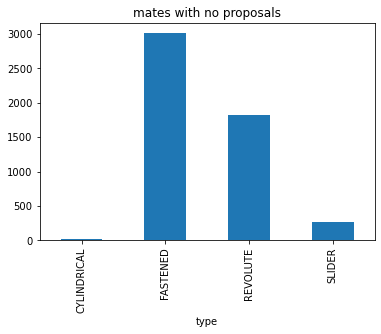

In [154]:
invalid_mate_counts.plot.bar(title='mates with no proposals')

In [156]:
invalid_mate_counts

type
CYLINDRICAL      18
FASTENED       3011
REVOLUTE       1828
SLIDER          266
Name: num_possible_mc_pairs, dtype: int64

In [92]:
mate_counts = mate_stats_df.groupby('type')['num_possible_mc_pairs'].sum()

<AxesSubplot:xlabel='type'>

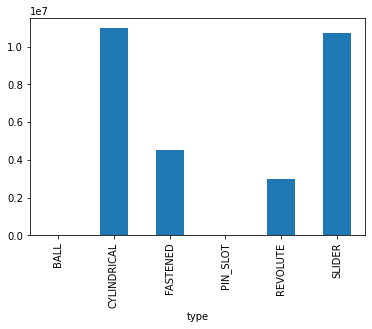

In [93]:
mate_counts.drop(['PARALLEL', 'PLANAR']).plot.bar()

In [50]:
mate_mcs = mate_stats_df.groupby('type')['num_possible_mc_pairs'].sum()

In [51]:
mate_mcs

type
BALL                3275
CYLINDRICAL      5559681
FASTENED          890808
PARALLEL       141039798
PLANAR          71305475
REVOLUTE          571816
SLIDER           5164891
Name: num_possible_mc_pairs, dtype: int64

In [53]:
weights = np.array([1/weight for weight in mate_mcs])

In [54]:
weights /= weights.max()

In [55]:
weights

array([1.00000000e+00, 5.89062574e-04, 3.67643757e-03, 2.32203963e-05,
       4.59291520e-05, 5.72736685e-03, 6.34088890e-04])

In [68]:
weights_df = ps.DataFrame({'weights': weights/weights[3]}, index=mate_mcs.index)

In [72]:
list(weights_df['weights'])

[43065.587175572524,
 25.3683256287546,
 158.32794272166393,
 1.0,
 1.9779658995329603,
 246.6524161618423,
 27.307410359676517]

In [73]:
print(np.array(weights_df['weights']))

[4.30655872e+04 2.53683256e+01 1.58327943e+02 1.00000000e+00
 1.97796590e+00 2.46652416e+02 2.73074104e+01]


In [83]:
sorted_weights = [1.0]
for t in mate_types:
    if t != 'PIN_SLOT':
        print(t, weights_df.loc[t,'weights'])
        sorted_weights.append(weights_df.loc[t,'weights'])
        

BALL 43065.587175572524
PARALLEL 1.0
SLIDER 27.307410359676517
REVOLUTE 246.6524161618423
CYLINDRICAL 25.3683256287546
PLANAR 1.9779658995329603
FASTENED 158.32794272166393


In [82]:
sorted_weights

[1.0,
 43065.587175572524,
 1.0,
 27.307410359676517,
 246.6524161618423,
 25.3683256287546,
 1.9779658995329603,
 158.32794272166393]

In [97]:
stats_df_filtered[lambda df: df['num_invalid_loaded_parts'] > 0]

,num_total_parts,num_invalid_loaded_parts,num_topologies,too_big,invalid_bbox,maxdim,num_normalized_parts_with_discrepancies,num_invalid_transformed_parts,initialized,num_mates,...,match_time,truncated_mc_pairs,truncation_time,reordering_time,conversion_time,invalid_topo_bboxes:,parts_with_invalid_topo_bboxes,num_mcs,skipped,has_mc_pairs
index,,,,,,,,,,,,,,,,,,,,,
122936,5,1,2117,False,False,0.064609,1.0,0.0,True,4.0,...,0.031878,False,0.063220,0.127627,2.311207,0.0,0.0,3464,False,True
107641,9,2,165,False,False,0.702500,0.0,0.0,True,8.0,...,0.002901,False,0.000612,0.001083,0.041090,0.0,0.0,311,False,True
107654,9,2,392,False,False,2.000000,0.0,0.0,True,8.0,...,0.002646,False,0.030492,0.068052,1.409005,0.0,0.0,1574,False,True
107667,4,1,2262,False,False,0.082598,0.0,0.0,True,3.0,...,0.000028,False,0.012554,0.020409,0.479623,0.0,0.0,4311,False,True
107723,4,1,2130,False,False,0.080000,0.0,0.0,True,3.0,...,0.020659,True,2.721498,2.827904,2.786508,0.0,0.0,4996,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119539,5,1,312,False,False,2.400000,0.0,0.0,True,4.0,...,0.004854,False,0.001521,0.002567,0.083961,0.0,0.0,916,False,True
120778,9,1,2612,False,False,2.044000,0.0,0.0,True,8.0,...,0.074214,True,2.405158,2.547153,2.861394,0.0,0.0,11408,False,True
121102,7,2,640,False,False,0.785000,0.0,0.0,True,7.0,...,0.012658,False,0.004640,0.007700,0.229555,0.0,0.0,2472,False,True


In [98]:
stats_df_filtered.shape

(19211, 26)

# Analyze negative examples in batches

In [186]:
import torch

In [256]:
negativestat_rows = []
negativestat_indices = []
ind = 0
torchpath = '/fast/jamesn8/assembly_data/assembly_torch2_fixsize/data'
for i,entry in enumerate(os.scandir(torchpath)):
    if i % 100 == 0:
        print('processed',i)
    batch = torch.load(entry.path)
    if not hasattr(batch, 'pair_indices'):
        continue
    pos_pairs = set()
    pos_comp_pairs = dict()
    for k in range(batch.part_edges.shape[1]):
        part_pair = batch.part_edges[:,k]
        if batch.pair_indices[k] >= 0:
            pos_pairs.add((part_pair[0].item(), part_pair[1].item()))
            comp_pair = batch.rigid_labels[part_pair]
            comp_pair = tuple(sorted([t.item() for t in comp_pair]))
            dist = batch.part_pair_feats[1,k].item()
            if comp_pair not in pos_comp_pairs:
                pos_comp_pairs[comp_pair] = dist
            else:
                pos_comp_pairs[comp_pair] = min(pos_comp_pairs[comp_pair], dist)
    for k in range(batch.part_edges.shape[1]):
        part_pair = batch.part_edges[:,k]
        if batch.pair_indices[k] < 0:
            stat = dict()
            stat['assembly'] = batch.assembly.item()
            
            comp_pair = batch.rigid_labels[part_pair]
            comp_pair = tuple(sorted([t.item() for t in comp_pair]))
            stat['has_alternate_mate_with_same_components'] = comp_pair in pos_comp_pairs
            if comp_pair in pos_comp_pairs:
                stat['alternate_mate_dist'] = pos_comp_pairs[comp_pair]
                
            
#             for j in range(2):
#                 new_pair = [part_pair[0].item(), part_pair[1].item()]
#                 comp = batch.rigid_labels[part_pair[j]].item()
#                 same_comp_inds = (batch.rigid_labels == comp).nonzero()
#                 for p in same_comp_inds:
#                     new_pair[j] = p.item()
#                     new_pair_sorted = tuple(sorted(new_pair))
#                     if new_pair_sorted in pos_pairs:
#                         stat['has_mate_with_component'] = True
#                         break
            
            
            stat['rigid_component0'] = batch.rigid_labels[part_pair[0]].item()
            stat['rigid_component1'] = batch.rigid_labels[part_pair[1]].item()
            stat['same_rigid_component'] = batch.rigid_labels[part_pair[0]].item() == batch.rigid_labels[part_pair[1]].item()
            stat['min_distance'] = batch.part_pair_feats[1,k].item()
            
            negativestat_indices.append(ind)
            negativestat_rows.append(stat)
            ind += 1
#     if i > 10:  
#         break

negativestat_df2 = ps.DataFrame(negativestat_rows, index = negativestat_indices)

processed 0
processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200
processed 1300
processed 1400
processed 1500
processed 1600
processed 1700
processed 1800
processed 1900
processed 2000
processed 2100
processed 2200
processed 2300
processed 2400
processed 2500
processed 2600
processed 2700
processed 2800
processed 2900
processed 3000
processed 3100
processed 3200
processed 3300
processed 3400
processed 3500
processed 3600
processed 3700
processed 3800
processed 3900
processed 4000
processed 4100
processed 4200
processed 4300
processed 4400
processed 4500
processed 4600
processed 4700
processed 4800
processed 4900
processed 5000
processed 5100
processed 5200
processed 5300
processed 5400
processed 5500
processed 5600
processed 5700
processed 5800
processed 5900
processed 6000
processed 6100
processed 6200
processed 6300
processed 6400
processed 6500
processed 6600
process

In [257]:
negativestat_df2[lambda df: df['has_alternate_mate_with_same_components']]

,assembly,has_alternate_mate_with_same_components,rigid_component0,rigid_component1,same_rigid_component,min_distance,alternate_mate_dist
39,79625,True,0,2,False,0.200634,1.998702e-01
103,79625,True,0,12,False,0.101753,1.009103e-01
148,79625,True,0,5,False,0.104072,1.032322e-01
190,79625,True,0,8,False,0.184754,1.839748e-01
200,79625,True,0,7,False,0.184472,1.836934e-01
...,...,...,...,...,...,...,...
452149,6884,True,0,0,True,0.047244,3.469447e-18
452150,6884,True,0,0,True,0.047244,3.469447e-18
452151,6884,True,0,11,False,0.047244,4.163336e-17
452152,6884,True,4,4,True,0.047244,0.000000e+00


In [223]:
same_comp_inds

NameError: name 'same_comp_inds' is not defined

In [258]:
alternate_rigid_negatives = negativestat_df2[lambda df: df['has_alternate_mate_with_same_components']].index

In [260]:
alternate_rigid_coincident_negatives = negativestat_df2[lambda df: (df['has_alternate_mate_with_same_components'] & (df['min_distance'] < 0.01))].index

In [215]:
same_rigid_negatives = negativestat_df[lambda df: df['same_rigid_component']].index

In [213]:
false_negatives = negativestat_df[lambda df: (df['same_rigid_component'] & (df['min_distance'] < 0.01))].index

In [259]:
len(alternate_rigid_negatives) / negativestat_df.shape[0]

0.4589271024069209

In [261]:
len(alternate_rigid_coincident_negatives) / negativestat_df.shape[0]

0.07180514644092385

In [216]:
len(same_rigid_negatives) / negativestat_df.shape[0]

0.2607785119726844

In [214]:
len(false_negatives) / negativestat_df.shape[0]

0.035758830241753574

In [217]:
len(negativestat_df[lambda df: df['min_distance'] < 0.01].index)/ negativestat_df.shape[0]

0.19531795946890287

# New statistics

In [25]:
part_df = part_df.set_index('Assembly')

In [26]:
mate_df_indexed = mate_df.set_index('Assembly')

## Comparing mate statistics before and after handselection

In [27]:
#with open('/fast/jamesn8/assembly_data/assembly_torch2_fixsize/full_trueonly_validonly_train.flist','r') as f:
with open('/projects/grail/jamesn8/projects/mechanical/Mechanical/data/dataset/valid_dataset.txt','r') as f:
    valid_data = [int(l.split('.')[0]) for l in f.readlines()]

In [28]:
valid_mates = mate_df_indexed.loc[valid_data]

<AxesSubplot:>

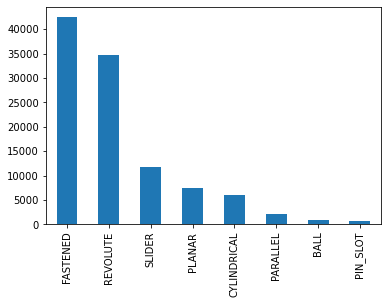

In [29]:
valid_mates['Type'].value_counts().plot.bar()

In [30]:
handselected_df = ps.read_csv('/projects/grail/jamesn8/projects/mechanical/Mechanical/data/dataset/handselected.csv', header=None)

In [31]:
handselected_mates = mate_df_indexed.loc[handselected_df[0]]

<AxesSubplot:>

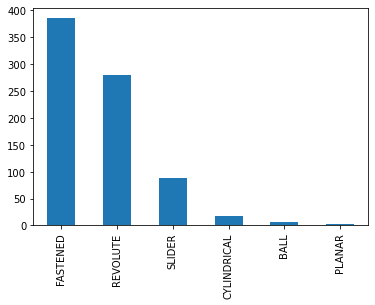

In [32]:
handselected_mates['Type'].value_counts().plot.bar()

## Assemblies with only simple mate types

In [33]:
def has_only_simple_mates(lst):
    for l in lst:
        if l not in {'FASTENED','REVOLUTE','CYLINDRICAL','SLIDER'}:
            return False
    return True

In [35]:
simple_only = valid_mates.groupby('Assembly')['Type'].agg(has_only_simple_mates)[lambda df: df]

In [40]:
with open('/projects/grail/jamesn8/projects/mechanical/Mechanical/data/dataset/simple_valid_dataset.txt','w') as f:
    for ind in simple_only[lambda df: df].index:
        f.write(str(ind) + '\n')

In [41]:
filter_file='/fast/jamesn8/assembly_data/assembly_torch2_fixsize/stats_distance/'
stats_df = ps.concat([ps.read_parquet(os.path.join(filter_file, fname)) for fname in os.listdir(filter_file) if fname.startswith('stats') and fname.endswith('.parquet')], axis=0).drop_duplicates()
stats_df_filtered = stats_df[lambda df: (df['num_unconnected_close'] == 0) & (df['num_connected_far'] == 0)]
filter_set = set(stats_df_filtered.index)

In [46]:
simple_only_filtered = simple_only.loc[[ind for ind in simple_only.index if ind in filter_set]]

In [47]:
simple_only_filtered

Assembly
40        True
90        True
121       True
175       True
200       True
          ... 
124997    True
125004    True
125016    True
125093    True
125102    True
Name: Type, Length: 4480, dtype: bool